<a href="https://colab.research.google.com/github/moist234/ECON3916-Statistical-Machine-Learning/blob/main/lab-02/Lab2_FredAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# The Economic Goal: To strip away "Money Illusion" by programmatically deflating nominal wages to reveal the stagnation of real purchasing power over the last 50 years.

In [13]:
# Install the FRED API library
!pip install fredapi
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
fred = Fred(api_key='716ad6d9cbf7b67fb22389689afba051')

In [14]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-06-01         31.26  321.500
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031


In [15]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-06-01         31.26  321.500  31.603325
2025-07-01         31.35  322.132  31.632132
2025-08-01         31.45  323.364  31.612130
2025-09-01         31.52  324.368  31.584426
2025-11-01         31.73  325.031  31.730000


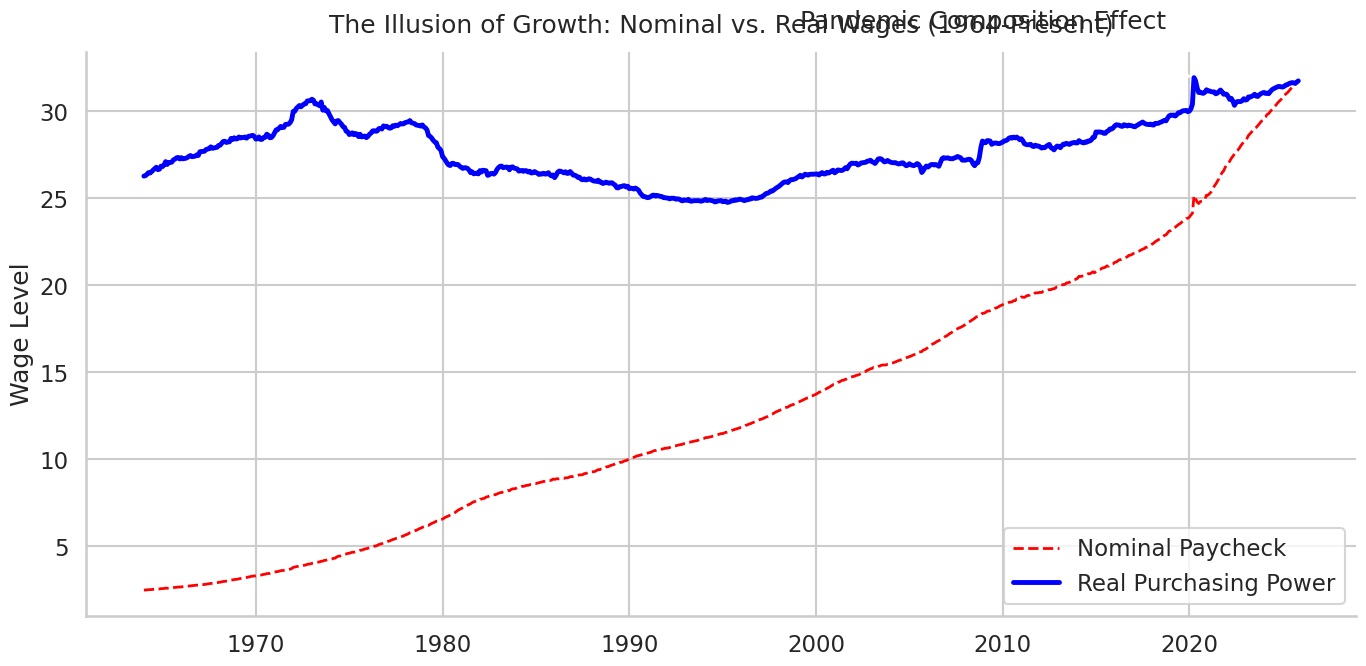

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Style ---
sns.set_theme(style="whitegrid", context="talk")  # whitegrid + larger, presentation-friendly defaults

# --- Figure ---
fig, ax = plt.subplots(figsize=(14, 7))

# --- Lines ---
ax.plot(
    df.index, df["Nominal_Wage"],
    linestyle="--", linewidth=2.0, color="red",
    label="Nominal Paycheck"
)

ax.plot(
    df.index, df["Real_Wage"],
    linestyle="-", linewidth=3.5, color="blue",
    label="Real Purchasing Power"
)

# --- Title / labels ---
ax.set_title("The Illusion of Growth: Nominal vs. Real Wages (1964-Present)", pad=14)
ax.set_xlabel("")
ax.set_ylabel("Wage Level")

# --- Annotation: 2020 spike in Real Wages ---
# Find the 2020 peak (works for daily/monthly/quarterly data)
mask_2020 = (df.index >= "2020-01-01") & (df.index <= "2020-12-31")
if mask_2020.any():
    real_2020 = df.loc[mask_2020, "Real_Wage"].dropna()
    if not real_2020.empty:
        spike_date = real_2020.idxmax()
        spike_val = real_2020.max()

        ax.annotate(
            "Pandemic Composition Effect",
            xy=(spike_date, spike_val),
            xytext=(spike_date - pd.DateOffset(months=18), spike_val * 1.08),
            arrowprops=dict(arrowstyle="->", linewidth=1.8),
            ha="right",
            va="bottom"
        )

# --- Legend / finishing touches ---
ax.legend(frameon=True, loc="best")
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

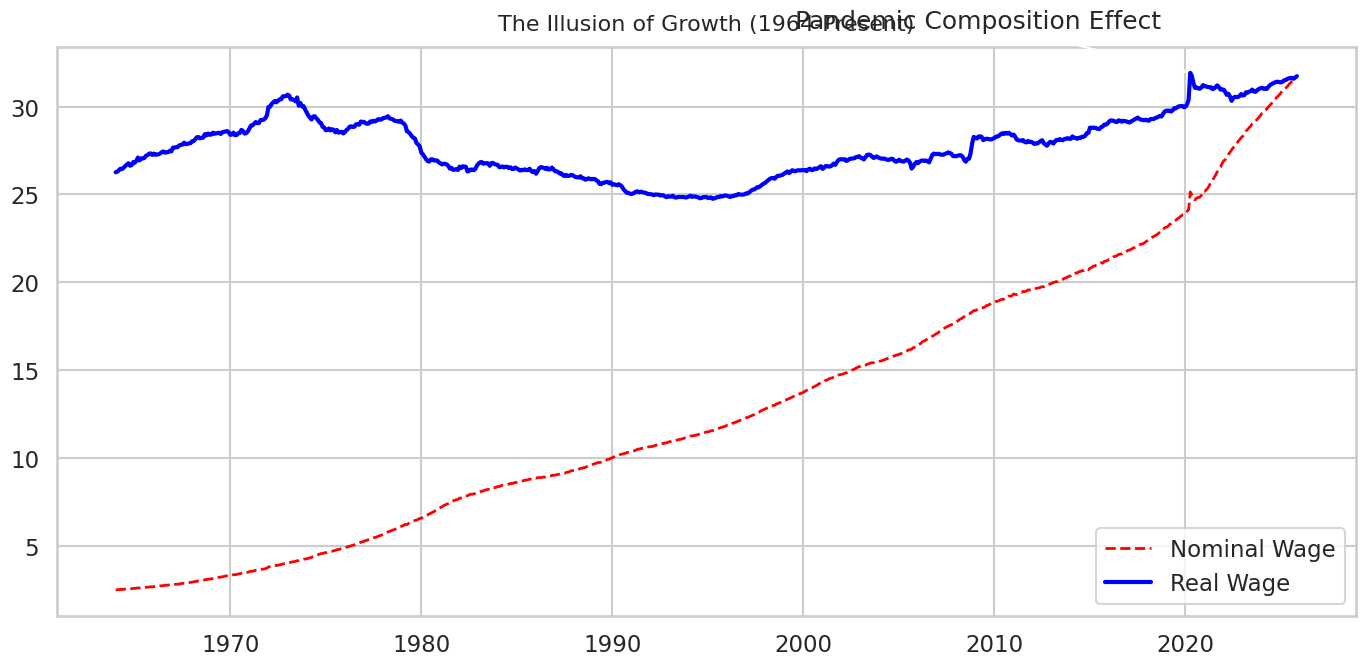

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Figure ---
plt.figure(figsize=(14, 7))

# --- Lines ---
plt.plot(
    df.index, df["Nominal_Wage"],
    linestyle="--", color="red", linewidth=2,
    label="Nominal Wage"
)

plt.plot(
    df.index, df["Real_Wage"],
    linestyle="-", color="blue", linewidth=3,
    label="Real Wage"
)

# --- Title ---
plt.title("The Illusion of Growth (1964-Present)", fontsize=16, pad=12)

# --- Annotate 2020 spike ---
mask_2020 = (df.index >= "2020-01-01") & (df.index <= "2020-12-31")
real_2020 = df.loc[mask_2020, "Real_Wage"]

if not real_2020.empty:
    spike_date = real_2020.idxmax()
    spike_value = real_2020.max()

    plt.annotate(
        "Pandemic Composition Effect",
        xy=(spike_date, spike_value),
        xytext=(spike_date - pd.DateOffset(months=18), spike_value * 1.08),
        arrowprops=dict(arrowstyle="->", linewidth=1.5),
        ha="right"
    )

# --- Legend & layout ---
plt.legend()
plt.tight_layout()
plt.show()

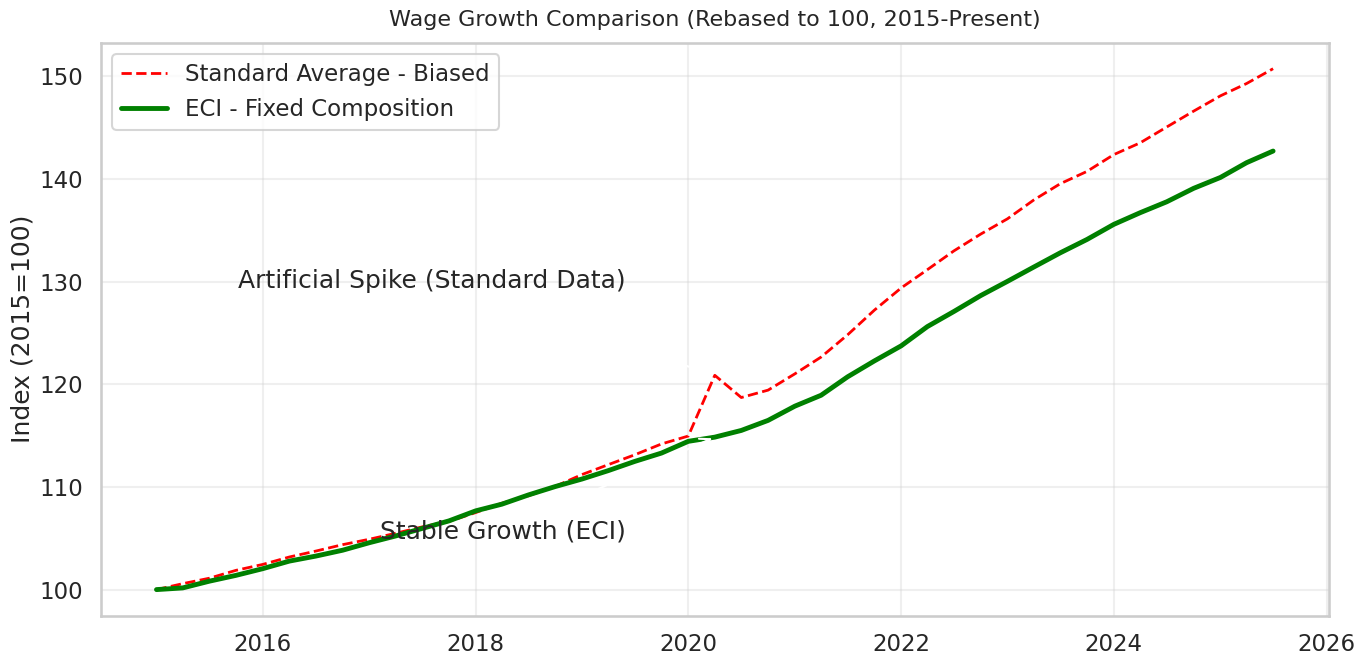

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Fetch Employment Cost Index (ECI) series from FRED
eci = fred.get_series("ECIWAG")          # pandas Series
eci.index = pd.to_datetime(eci.index)    # ensure DatetimeIndex

# Ensure wages index is datetime too
wages = wages.copy()
wages.index = pd.to_datetime(wages.index)

# 2) Filter both to 2015-01-01 onwards
start = "2015-01-01"
w_ = wages.loc[start:].dropna()
e_ = eci.loc[start:].dropna()

# Align on common dates (important if frequencies differ)
common_idx = w_.index.intersection(e_.index)
w_ = w_.loc[common_idx]
e_ = e_.loc[common_idx]

# 3) Rebase both to 100
w_rebased = (w_ / w_.iloc[0]) * 100
e_rebased = (e_ / e_.iloc[0]) * 100

# 4) Plot
plt.figure(figsize=(14, 7))
plt.plot(
    w_rebased.index, w_rebased,
    linestyle="--", color="red", linewidth=2,
    label="Standard Average - Biased"
)
plt.plot(
    e_rebased.index, e_rebased,
    linestyle="-", color="green", linewidth=3.5,
    label="ECI - Fixed Composition"
)

plt.title("Wage Growth Comparison (Rebased to 100, 2015-Present)", fontsize=16, pad=12)
plt.ylabel("Index (2015=100)")
plt.legend()
plt.grid(True, alpha=0.3)

# 5) Annotate divergence in 2020
mask_2020 = (w_rebased.index >= "2020-01-01") & (w_rebased.index <= "2020-12-31")
if mask_2020.any():
    # pick the 2020 point where the gap is largest
    gap = (w_rebased.loc[mask_2020] - e_rebased.loc[mask_2020]).dropna()
    if not gap.empty:
        div_date = gap.idxmax()
        w_val = w_rebased.loc[div_date]
        e_val = e_rebased.loc[div_date]

        plt.annotate(
            "Artificial Spike (Standard Data)",
            xy=(div_date, w_val),
            xytext=(div_date - pd.DateOffset(months=10), w_val + 8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5),
            ha="right", va="bottom"
        )

        plt.annotate(
            "Stable Growth (ECI)",
            xy=(div_date, e_val),
            xytext=(div_date - pd.DateOffset(months=10), e_val - 8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5),
            ha="right", va="top"
        )

plt.tight_layout()
plt.show()